# Data

In [13]:
import pandas as pd
import numpy as np

df = pd.DataFrame( columns = ['cat_1', 'cat_2'] )

n = 3
m = 4

sample_size = 100

df['cat_1'] = np.random.randint(1, n, sample_size)
df['cat_2'] = np.random.randint(1, m, sample_size)
df['random_x'] = np.random.random(sample_size)

beta = 10*np.random.rand()

shift_cat1 = -1.5*np.random.rand(df['cat_1'].nunique())
shift_cat2 = -2.5*np.random.rand(df['cat_2'].nunique())

lin_model = beta* df['random_x'] + shift_cat1[df['cat_1'].values - 1] + shift_cat2[df['cat_2'].values - 1] + \
np.random.rand(sample_size)

probs = ( 1 + np.exp(lin_model) ) ** -1.0

labels = np.ones(df.shape[0], ).astype(int)

labels[probs < 0.5] = 0

df['random_y'] = labels

# Data Visualization

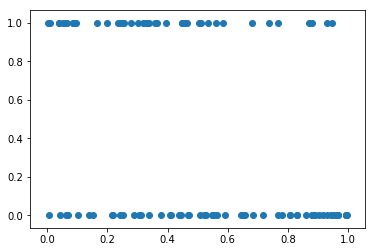

In [14]:
import matplotlib.pyplot as plt

plt.scatter( x = df['random_x'], y = df['random_y'] )

plt.show()

# Modelling

In [15]:
from bayes_linear import BGLClassifier

model = BGLClassifier(numeric_cols = ['random_x'], target_col = 'random_y', cat_cols = ['cat_1', 'cat_2'] )

In [16]:
model.fit(df)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d9553e5d8a19efb24905ccaac89d46d6 NOW.
/usr/local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [17]:
print(model.model)

Inference for Stan model: anon_model_d9553e5d8a19efb24905ccaac89d46d6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_cat_1         0.45    0.03   0.32  -0.17    0.2   0.44   0.68   1.13    126   1.03
mu_cat_2         0.62    0.01   0.19   0.25   0.49   0.63   0.73   0.99    295   1.02
mu_b           -10.54    0.91  19.14 -51.01 -17.46 -11.46  -3.61  30.98    446   1.01
sigma_cat_1      3.58    0.13   1.13   1.69   2.71   3.49   4.51   5.82     81   1.05
sigma_cat_2      3.95    0.08   1.03   2.11   3.23   3.94   4.48   6.34    179   1.02
sigma_b         15.03    1.67  12.26   0.14   4.72  12.75  23.16  42.66     54   1.06
sigma            1.22    0.16   0.61   0.38    0.8   1.11   1.59   2.54     15   1.31
beta[0]        -12.02    0.39   2.98  -18.6 -13.76 -11.74  -9.95  -7.15     57   1.07
shift_cat_1[0]  -0.39    0.11   1.86 

# Validation Performance

In [18]:
val_size = 1000

df_val = pd.DataFrame( columns = ['random_x'])

df_val['random_x'] = np.random.rand(val_size)

df_val['cat_1'] = np.random.randint(1, n, val_size)
df_val['cat_2'] = np.random.randint(1, m, val_size)

lin_model = beta* df_val['random_x'] + \
shift_cat1[df_val['cat_1'].values - 1] + shift_cat2[df_val['cat_2'].values - 1]

probs = ( 1 + np.exp(lin_model) ) ** -1.0

val_labels = np.ones(df_val.shape[0], ).astype(int)

val_labels[probs < 0.5] = 0

In [19]:
train_accuracy = model.score(df, labels)
val_accuracy = model.score(df_val, val_labels)

print('Train Mean Accuracy: ' + str(train_accuracy))
print('Validation Mean Accuracy: ' + str(val_accuracy))

Train Mean Accuracy: 0.96
Validation Mean Accuracy: 0.756


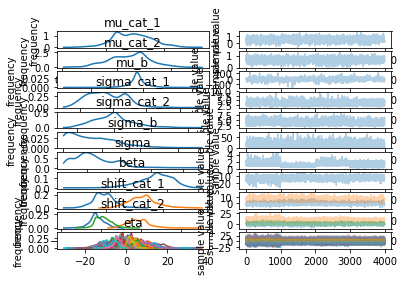

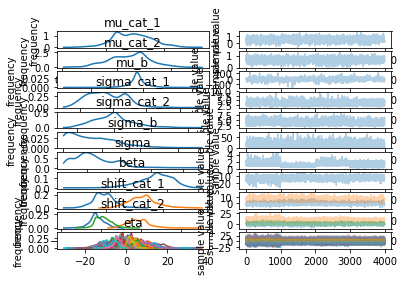

In [20]:
model.model.plot()

# Non-Bayesian Performance

## Label Encoded Data

In [21]:
from sklearn.linear_model import LogisticRegressionCV

lin_reg = LogisticRegressionCV( cv = 5 )

lin_reg.fit( df[['random_x', 'cat_1', 'cat_2']], df['random_y'] )

accuracy_train = lin_reg.score, ( df[['random_x', 'cat_1', 'cat_2']], df['random_y'] )
accuracy_val = lin_reg.score( df_val[['random_x', 'cat_1', 'cat_2']], val_labels )

print('Train Mean Accuracy: ' + str(accuracy_train))
print('Validation Mean Accuracy: ' + str(accuracy_val))

## One Hot Encoded Data

In [23]:
df_val['random_y'] = val_labels

df['is_train'] = 1
df_val['is_train'] = 0

merged_df = pd.concat( [df, df_val], axis = 0, ignore_index = True )

def oneHotEncode(dff, cat_cols ):
    
    res = dff.copy()
    
    for cat_col in cat_cols:
        
        cat_dummies = pd.get_dummies( res[cat_col].astype(object) )
        cat_dummies = cat_dummies.rename( columns = {col : cat_col + '_' + str(col) for col in cat_dummies.columns} )
        
        res = pd.concat( [res.drop(cat_col, axis = 1), cat_dummies], axis = 1 )
        
    return res


merged_df = oneHotEncode( merged_df, ['cat_1', 'cat_2'] )

In [25]:
indices = merged_df['is_train'] == 1

df = merged_df.loc[indices, :].reset_index(drop = True)
df_val = merged_df.loc[~indices, :].reset_index(drop = True)

lin_reg = LogisticRegressionCV( cv = 5 )

train_cols = [ col for col in df.columns if not col in ['is_train', 'random_y'] ]

lin_reg.fit( df[train_cols], df['random_y'] )

accuracy_train = lin_reg.score( df[train_cols], df['random_y'])
accuracy_val = lin_reg.score( df_val[train_cols], val_labels )

print('Train Mean Accuracy: ' + str( accuracy_train ) )
print('Validation Mean Accuracy: ' + str( accuracy_val ) )

Train Mean Accuracy: 0.96
Validation Mean Accuracy: 0.776


# Comments

This shows that, with the presence of white noise, the Bayesian model is more equipped to learn noisy data and make better predictions, while also taking care of the categorial differences in the data.